# Exploratory Data Analysis

## Variables Description

- **flight_id**: A unique identifier assigned to each flight.
- **date**: The date when the flight took place.
- **callsign**: The encrypted callsign associated with the flight.
- **adep**: The code of the departure airport.
- **name_adep**: The name of the departure airport.
- **country_code_adep**: The country code of the departure airport.
- **ades**: The code of the destination airport.
- **name_ades**: The name of the destination airport.
- **country_code_ades**: The country code of the destination airport.
- **actual_offblock_time**: The time when the aircraft started to move from its parking position.
- **arrival_time**: The time of arrival at the destination airport.
- **aircraft_type**: The type of aircraft used for the flight.
- **wtc**: The wake turbulence category of the aircraft.
- **airline**: The encrypted identifier of the airline operating the flight.
- **flight_duration**: The duration of the flight in minutes.
- **taxiout_time**: The time spent taxiing out from the departure airport.
- **flown_distance**: The distance flown during the flight in kilometers.
- **tow**: The target variable representing the actual TakeOff Weight (TOW) of the aircraft.

In [95]:
!pip install meteostat

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm
from meteostat import Stations, Daily
from datetime import timedelta
import multiprocessing as mp

In [97]:
# Load the datasets
challenge_set = pd.read_csv('./data/challenge_set.csv')
submission_set = pd.read_csv('./data/submission_set.csv')
trajectories_set = pd.read_csv('./data/trajectory_features.csv')

challenge_set = trajectories_set[trajectories_set['flight_id'].isin(challenge_set['flight_id'])]
submission_set = trajectories_set[trajectories_set['flight_id'].isin(submission_set['flight_id'])]

# Display the first few rows of the datasets to understand their structure
challenge_set.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
flight_id,248763780,248760618,248753824,248753852,248755934,248762583,248758528,248752667,248762188,248753189,...,258072846,258057853,258071492,258060782,258067496,258058361,258071247,258059152,258072276,258069969
date,2022-01-01,2022-01-01,2022-01-01,2022-01-01,2022-01-01,2022-01-01,2022-01-01,2022-01-01,2022-01-01,2022-01-01,...,2022-12-31,2022-12-31,2022-12-31,2022-12-31,2022-12-31,2022-12-31,2022-12-31,2022-12-31,2022-12-31,2022-12-31
callsign,3840d84f25d3f5fcc0a1be3076bb4039,f6f610e73002b8892a239a81321f7f1d,139670936660762c230ca92556ba842b,509dc61bb54fbab0e5406067c95603e2,d0610d000dcf26b1d7bba8103ecc393d,e6d5d070016d21108f8bd2bd643202ac,1f51e76bb1001c4f9de991288aacb326,52d1b50f92590b36489a929375be10f6,256265f000acb4a06cd680b3df7c9897,8191fa049d6f1a6cb432a98d97bf960c,...,5ea802e68573752dc98d7623d897a915,b1de87e85987c58b0d29fa4e72e3f961,49c815d2ca2e8c50b01473b12fd30119,92eba53fed3c3914105be1de666ca203,80e0832fdc79cbba84dff5e9e06bb883,85ee68e5b7b5acf24ba00d1318eca1e8,570cf7d5ebbd691bcba63e7466607da7,5a7e43e4f981539ae3d3b1cb31591b7c,a1c078516f9f9e90cacec61854cad45b,6c98fcaa191dec632b87b46511f1d2da
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
name_adep,London Heathrow,Barcelona,Stockholm Arlanda,Zurich,Dublin,Oslo,Belfast City,iGA Istanbul,Los Angeles,iGA Istanbul,...,Rome Fiumicino,London Heathrow,iGA Istanbul,Zurich,Hanover,Paris Charles de Gaulle,iGA Istanbul,Dusseldorf,Paris Charles de Gaulle,Madrid Barajas
country_code_adep,GB,ES,SE,CH,IE,NO,GB,TR,US,TR,...,IT,GB,TR,CH,DE,FR,TR,DE,FR,ES
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
name_ades,Cork,Miami,Chicago O'Hare,Philadelphia,London Heathrow,Alicante,London Heathrow,Belgrade,iGA Istanbul,Ankara,...,Brussels,Zurich,Milan Malpensa,Thessaloniki,Vienna,Miami,Berlin Brandenburg,Dublin,Dublin,New York JFK
country_code_ades,IE,US,US,US,GB,ES,GB,RS,TR,TR,...,BE,CH,IT,GR,AT,US,DE,IE,IE,US
actual_offblock_time,2022-01-01T13:46:00Z,2022-01-01T09:55:00Z,2022-01-01T09:39:00Z,2022-01-01T11:04:00Z,2022-01-01T12:36:00Z,2022-01-01T10:24:52Z,2022-01-01T07:41:00Z,2022-01-01T05:21:00Z,2022-01-01T21:26:00Z,2022-01-01T15:00:00Z,...,2022-12-31T09:47:00Z,2022-12-31T09:52:00Z,2022-12-31T09:34:00Z,2022-12-31T09:39:00Z,2022-12-31T09:42:00Z,2022-12-31T09:38:00Z,2022-12-31T09:27:00Z,2022-12-31T09:52:00Z,2022-12-31T09:37:00Z,2022-12-31T09:38:00Z


In [98]:
# Ensure you are working with a copy of the DataFrame
challenge_set = challenge_set.copy()
submission_set = submission_set.copy()

# Convert 'date' columns to datetime format
challenge_set['date'] = pd.to_datetime(challenge_set['date'])
submission_set['date'] = pd.to_datetime(submission_set['date'])

# Find the min and max dates in both datasets
min_challenge_date = challenge_set['date'].min()
max_challenge_date = challenge_set['date'].max()

min_submission_date = submission_set['date'].min()
max_submission_date = submission_set['date'].max()

(min_challenge_date, max_challenge_date, min_submission_date, max_submission_date)

(Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'),
 Timestamp('2022-01-01 00:00:00'),
 Timestamp('2022-12-31 00:00:00'))

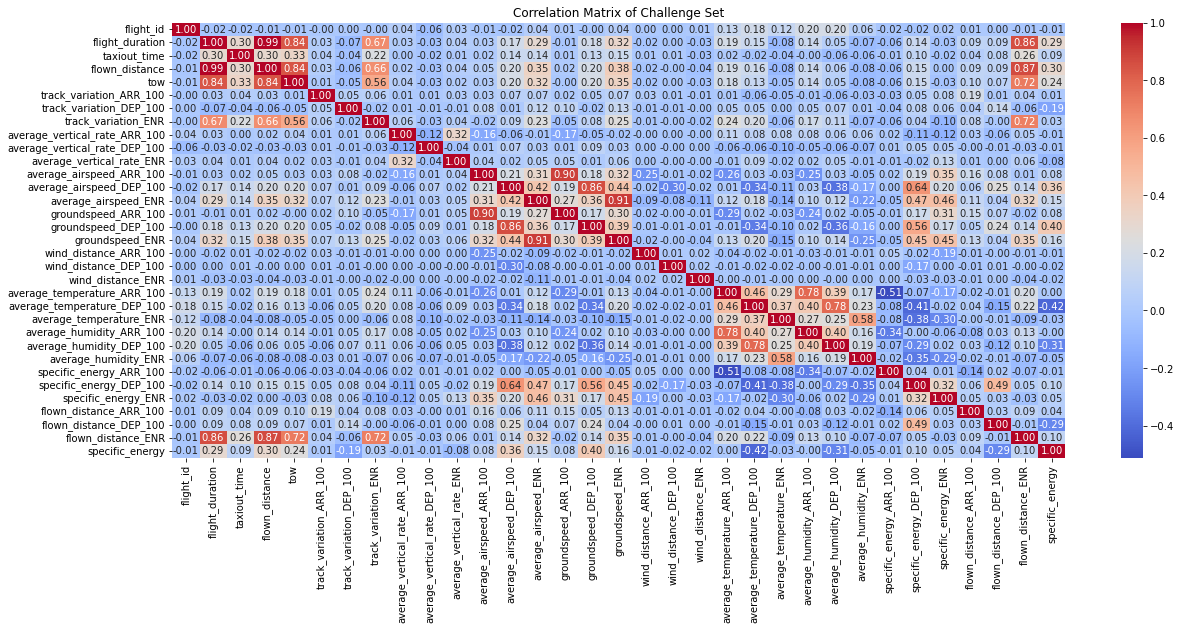

(          flight_id  flight_duration   taxiout_time  flown_distance  \
 count  3.690130e+05    369013.000000  369013.000000   369013.000000   
 mean   2.535220e+08       145.876779      13.489709     1021.728581   
 std    2.688565e+06       139.337587       5.779555     1128.171163   
 min    2.487506e+08         8.000000       0.000000       19.000000   
 25%    2.512296e+08        59.000000      10.000000      338.000000   
 50%    2.536200e+08       100.000000      12.000000      647.000000   
 75%    2.559059e+08       164.000000      16.000000     1113.000000   
 max    2.580745e+08      1013.000000      90.000000     7272.000000   
 
                  tow  track_variation_ARR_100  track_variation_DEP_100  \
 count  369013.000000             3.454850e+05             3.140470e+05   
 mean    79482.257229                      inf                      inf   
 std     53250.919631                      NaN                      NaN   
 min     14944.000000             0.000000e+00    

In [99]:
# Summary statistics of the challenge set
challenge_summary = challenge_set.describe()

# Check for missing values
missing_values = challenge_set.isnull().sum()

# Drop non-numeric columns before computing the correlation matrix
numeric_challenge_set = challenge_set.select_dtypes(include=['number'])

# Correlation matrix to check relationships between numerical features
correlation_matrix = numeric_challenge_set.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

# Display the summary statistics and missing values
challenge_summary, missing_values

In [100]:
# Checking for missing values in each column and displaying the result as a DataFrame
missing_values = trajectories_set.isnull().sum()
missing_values_df = pd.DataFrame(missing_values, columns=['Missing Values'])
missing_values_df['Percentage'] = (missing_values_df['Missing Values'] / len(trajectories_set)) * 100
missing_values_df

,Missing Values,Percentage
flight_id,0,0.000000
date,0,0.000000
callsign,0,0.000000
adep,0,0.000000
name_adep,0,0.000000
country_code_adep,0,0.000000
ades,0,0.000000
name_ades,0,0.000000
country_code_ades,0,0.000000
actual_offblock_time,0,0.000000


In [101]:
list(challenge_set.columns)

['flight_id',
 'date',
 'callsign',
 'adep',
 'name_adep',
 'country_code_adep',
 'ades',
 'name_ades',
 'country_code_ades',
 'actual_offblock_time',
 'arrival_time',
 'aircraft_type',
 'wtc',
 'airline',
 'flight_duration',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_100',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_100',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_100',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_100',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_100',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_100',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_100',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_100',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_100',
 'flown_distance_E

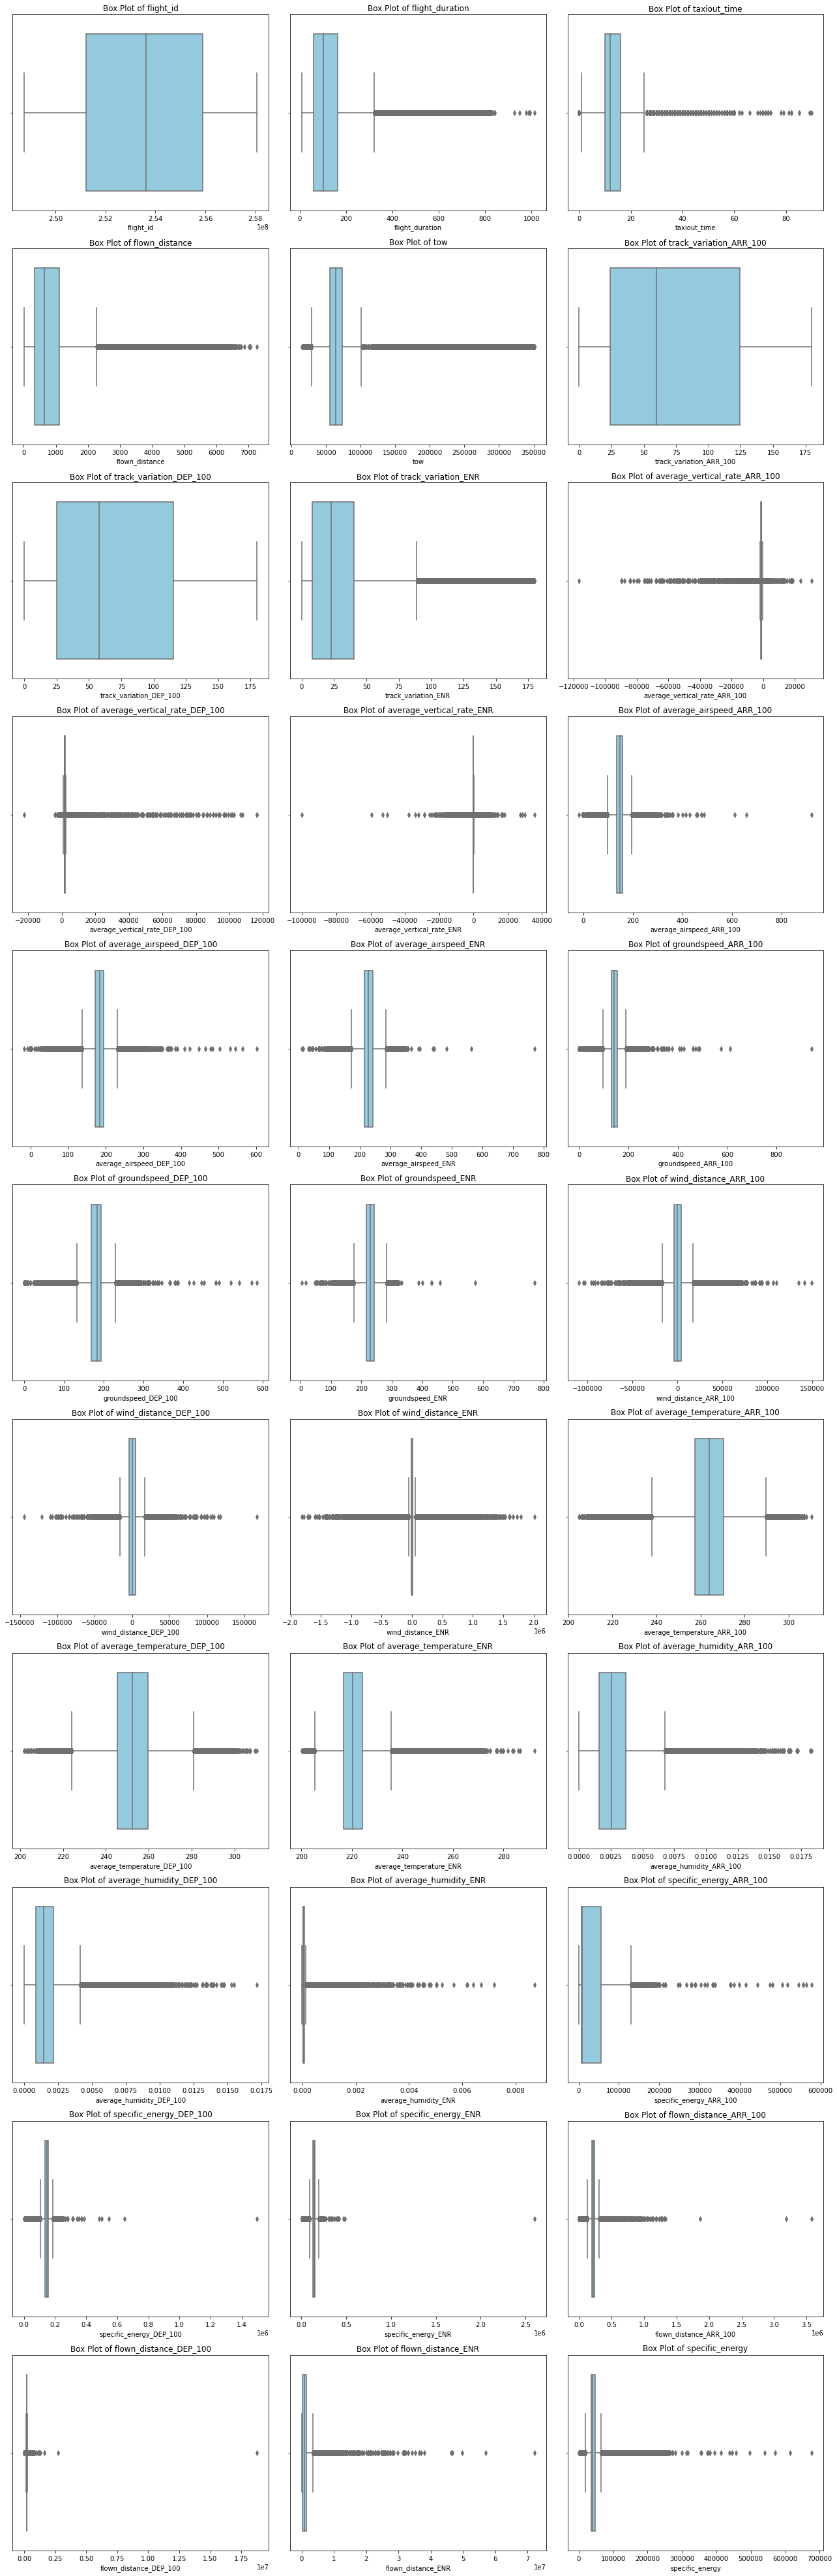

In [102]:
# Extract all numerical columns from the dataset
numerical_columns = challenge_set.select_dtypes(include=['number']).columns

# Set the number of plots per row (3 per row for narrow columns)
plots_per_row = 3
total_plots = len(numerical_columns)
rows = (total_plots + plots_per_row - 1) // plots_per_row  # Calculate the required number of rows

# Set up the figure size, adjusting for the number of rows
plt.figure(figsize=(18, rows * 5))  # Adjust the width and height based on rows

for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(rows, plots_per_row, i)  # Arrange the plots in the grid with three plots per row
    
    # Plotting a boxplot for each numerical feature
    sns.boxplot(x=challenge_set[feature], color='skyblue')
    
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(f'{feature}')
    
plt.tight_layout()
plt.show()

In [103]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = challenge_set['country_code_adep'].unique()
ades_countries = challenge_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AO', 'AT', 'AW', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BJ', 'BR', 'BY', 'CA', 'CD', 'CG', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ES', 'ET', 'FI', 'FR', 'GB', 'GE', 'GH', 'GI', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KR', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MU', 'MX', 'MY', 'NG', 'NL', 'NO', 'NP', 'OM', 'PA', 'PH', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'RW', 'SA', 'SD', 'SE', 'SI', 'SK', 'SL', 'SN', 'SO', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'VE', 'VN', 'XK', 'ZA']


In [104]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = submission_set['country_code_adep'].unique()
ades_countries = submission_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries_sub = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries_sub))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BH', 'BY', 'CA', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ER', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MX', 'NL', 'NO', 'OM', 'PA', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SI', 'SK', 'SL', 'SN', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'XK', 'ZA']


In [105]:
set(all_countries_sub) - set(all_countries)

{'ER'}

In [106]:
set(all_countries) - set(all_countries_sub)

{'AO',
 'AW',
 'BB',
 'BD',
 'BJ',
 'BR',
 'CD',
 'CG',
 'ET',
 'GH',
 'GI',
 'KR',
 'MU',
 'MY',
 'NG',
 'NP',
 'PH',
 'RW',
 'SD',
 'SO',
 'VE',
 'VN'}

In [107]:
def extract_time_features(df):
    df = df.copy()
    # Convert datetime strings to datetime objects
    df.loc[:, 'actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'])
    df.loc[:, 'arrival_time'] = pd.to_datetime(df['arrival_time'])
    
    # Extract basic time features
    df.loc[:, 'offblock_hour'] = df['actual_offblock_time'].dt.hour
    df.loc[:, 'offblock_minute'] = df['actual_offblock_time'].dt.minute
    df.loc[:, 'offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek
    df.loc[:, 'offblock_month'] = df['actual_offblock_time'].dt.month
    df.loc[:, 'offblock_week_of_year'] = df['actual_offblock_time'].dt.isocalendar().week
    df.loc[:, 'offblock_season'] = df['offblock_month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 
                                                               'Spring' if x in [3, 4, 5] else
                                                               'Summer' if x in [6, 7, 8] else 'Fall')
    
    df.loc[:, 'arrival_hour'] = df['arrival_time'].dt.hour
    df.loc[:, 'arrival_minute'] = df['arrival_time'].dt.minute

    # Calculate the duration in minutes between offblock and arrival
    df.loc[:, 'offblock_to_arrival_duration'] = (df['arrival_time'] - df['actual_offblock_time']).dt.total_seconds() / 60
    
    # Add boolean flags for weekends and rush hours
    df.loc[:, 'is_offblock_weekend'] = df['offblock_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df.loc[:, 'is_offblock_rush_hour'] = df['offblock_hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)
    
    return df

# Create additional duration-based features
def create_duration_features(df):
    df = df.copy()
    # Replace zero or negative values in flight_duration to avoid division errors
    df.loc[:, 'flight_duration'] = df['flight_duration'].replace(0, np.nan)
    df.loc[:, 'taxiout_time'] = df['taxiout_time'].replace(0, np.nan)
    
    # Fill NaN values in taxiout_time with the median or a reasonable default
    df.loc[:, 'taxiout_time'] = df['taxiout_time'].fillna(df['taxiout_time'].median())
    
    # Calculate the ratio of taxiout time to flight duration with error handling
    df.loc[:, 'taxi_ratio'] = df.apply(lambda row: row['taxiout_time'] / row['flight_duration'] 
                                       if pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in taxi_ratio with the median of taxi_ratio
    df.loc[:, 'taxi_ratio'] = df['taxi_ratio'].fillna(df['taxi_ratio'].median())
    
    # Calculate the average flight speed (distance per minute) with error handling
    df.loc[:, 'flight_speed'] = df.apply(lambda row: row['flown_distance'] / row['flight_duration'] 
                                         if pd.notnull(row['flown_distance']) and pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in flight_speed with the median value or a reasonable default
    df.loc[:, 'flight_speed'] = df['flight_speed'].fillna(df['flight_speed'].median())
    
    # Normalize taxi_ratio by the median value to control for large values
    df.loc[:, 'normalized_taxi_ratio'] = df['taxi_ratio'] / df['taxi_ratio'].median()
    
    # Categorical features for flight duration buckets
    df.loc[:, 'flight_duration_category'] = pd.cut(df['flight_duration'], bins=[0, 60, 180, 300, np.inf], 
                                                   labels=['Very Short', 'Short', 'Medium', 'Long'], right=False)
    
    # Speed per distance feature for more detailed analysis
    df.loc[:, 'speed_per_distance'] = df.apply(lambda row: row['flight_speed'] / row['flown_distance'] 
                                               if pd.notnull(row['flight_speed']) and pd.notnull(row['flown_distance']) else np.nan, axis=1)
    
    # Fill NaN values in speed_per_distance with the median value or a reasonable default
    df.loc[:, 'speed_per_distance'] = df['speed_per_distance'].fillna(df['speed_per_distance'].median())
    
    # Cumulative mean of flight speed to capture trends over time (if data is ordered by time)
    df.loc[:, 'cumulative_avg_speed'] = df['flight_speed'].expanding().mean()
    
    # Handle edge cases and set up conditions for further analysis
    df.loc[:, 'taxi_ratio'] = df['taxi_ratio'].replace([np.inf, -np.inf], np.nan)
    df.loc[:, 'flight_speed'] = df['flight_speed'].replace([np.inf, -np.inf], np.nan)
    
    return df

# Group airports by region based on country codes
def group_airports_by_region(df):
    df = df.copy()
    # Define country groups for regions
    europe_countries = ['GB', 'FR', 'DE', 'ES', 'IT', 'SE', 'CH', 'NL', 'AT', 'IE', 'BE', 'DK', 'FI', 'GR', 'HU', 
                        'IS', 'LT', 'LU', 'LV', 'MT', 'NO', 'PL', 'PT', 'RO', 'SI', 'SK', 'CZ', 'EE', 'BG', 'CY']
    north_america_countries = ['US', 'CA', 'MX']
    south_america_countries = ['BR', 'AR', 'CL', 'CO', 'PE', 'VE', 'UY', 'PY', 'BO', 'EC', 'GY', 'SR']
    middle_east_countries = ['AE', 'SA', 'IL', 'IR', 'IQ', 'JO', 'KW', 'OM', 'QA', 'BH', 'LB', 'SY', 'YE']
    asia_countries = ['JP', 'CN', 'KR', 'IN', 'PK', 'BD', 'VN', 'PH', 'TH', 'MY', 'ID', 'SG', 'MN', 'KZ', 'TM', 'UZ', 'KG']
    africa_countries = ['ZA', 'NG', 'EG', 'DZ', 'MA', 'KE', 'TZ', 'GH', 'ET', 'CI', 'SN', 'SD', 'AO', 'LR', 'RW', 'ER']
    other_countries = set(df['country_code_adep'].unique()).union(set(df['country_code_ades'].unique())) - set(
        europe_countries + north_america_countries + south_america_countries + middle_east_countries + asia_countries + africa_countries)

    # Apply region categorization based on country codes
    def categorize_region(code):
        if code in europe_countries:
            return 'Europe'
        elif code in north_america_countries:
            return 'North America'
        elif code in south_america_countries:
            return 'South America'
        elif code in middle_east_countries:
            return 'Middle East'
        elif code in asia_countries:
            return 'Asia'
        elif code in africa_countries:
            return 'Africa'
        elif code in other_countries:
            return 'Other'
        else:
            return 'Unknown'

    # Apply region classification for adep and ades
    df.loc[:, 'adep_region'] = df['country_code_adep'].apply(categorize_region)
    df.loc[:, 'ades_region'] = df['country_code_ades'].apply(categorize_region)

    return df

# Extract country-related features
def extract_country_features(df):
    df = df.copy()
    # Basic feature indicating if the flight is within the same country
    df.loc[:, 'same_country_flight'] = (df['country_code_adep'] == df['country_code_ades']).astype(int)

    # Feature indicating if the flight is within the same region
    df.loc[:, 'same_region_flight'] = (df['adep_region'] == df['ades_region']).astype(int)

    # Flight direction based on regions: North-South, East-West, or Other
    df.loc[:, 'flight_direction'] = df.apply(
        lambda row: 'North-South' if row['adep_region'] in ['North America', 'Europe'] and row['ades_region'] in ['South America', 'Africa']
        else 'East-West' if row['adep_region'] in ['Europe', 'Asia'] and row['ades_region'] in ['North America']
        else 'Other', axis=1)

    # Create a feature indicating if the flight is intercontinental
    intercontinental_regions = ['Europe', 'North America', 'South America', 'Middle East', 'Asia', 'Africa']
    df.loc[:, 'is_intercontinental'] = df.apply(
        lambda row: 1 if row['adep_region'] in intercontinental_regions and 
                         row['ades_region'] in intercontinental_regions and 
                         row['adep_region'] != row['ades_region'] else 0, axis=1)
    return df

def create_interactions(df):
    df = df.copy()
    # Create interaction features between airspeed and specific energy for different flight phases
    df.loc[:, 'airspeed_specific_energy_ARR'] = df['average_airspeed_ARR_100'] * df['specific_energy_ARR_100']
    df.loc[:, 'airspeed_specific_energy_DEP'] = df['average_airspeed_DEP_100'] * df['specific_energy_DEP_100']
    df.loc[:, 'airspeed_specific_energy_ENR'] = df['average_airspeed_ENR'] * df['specific_energy_ENR']
    return df

def create_bins(df):
    df = df.copy()
    # Create bins (discretization) for temperature and humidity into 5 categories
    df.loc[:, 'temperature_bins_ARR'] = pd.cut(df['average_temperature_ARR_100'], bins=5, labels=False)
    df.loc[:, 'humidity_bins_DEP'] = pd.cut(df['average_humidity_DEP_100'], bins=5, labels=False)
    return df

def create_ratios(df):
    df = df.copy()
    # Create ratio features such as vertical rate to airspeed for arrival and departure phases
    df.loc[:, 'vertical_rate_airspeed_ratio_ARR'] = df['average_vertical_rate_ARR_100'] / df['average_airspeed_ARR_100']
    df.loc[:, 'vertical_rate_airspeed_ratio_DEP'] = df['average_vertical_rate_DEP_100'] / df['average_airspeed_DEP_100']
    return df

# Function to remove original columns after feature extraction
def remove_columns(df, columns_to_remove):
    # Remove original columns since features have been extracted
    df = df.drop(columns_to_remove, axis=1)
    return df

# List of columns to remove after feature extraction
columns_to_remove = ['name_adep', 'name_ades', 'country_code_adep', 'country_code_ades', 'flight_id', 'callsign', 
                     'actual_offblock_time', 'arrival_time', 'flight_duration']

# Apply all functions to the challenge set
challenge_set = challenge_set.copy()
cleaned_challenge_set = extract_time_features(challenge_set)
print("extract_time_features completed")

cleaned_challenge_set = create_duration_features(cleaned_challenge_set)
print("create_duration_features completed")

cleaned_challenge_set = group_airports_by_region(cleaned_challenge_set)
print("group_airports_by_region completed")

cleaned_challenge_set = extract_country_features(cleaned_challenge_set)
print("extract_country_features completed")

cleaned_challenge_set = create_interactions(cleaned_challenge_set)
print("create_interactions completed")

cleaned_challenge_set = create_bins(cleaned_challenge_set)
print("create_bins completed")

cleaned_challenge_set = create_ratios(cleaned_challenge_set)
print("create_ratios completed")

cleaned_challenge_set = remove_columns(cleaned_challenge_set, columns_to_remove)
print("remove_columns completed")

# Apply all functions to the submission set
submission_set = submission_set.copy()
cleaned_submission_set = extract_time_features(submission_set)
print("extract_time_features completed on submission_set")

cleaned_submission_set = create_duration_features(cleaned_submission_set)
print("create_duration_features completed on submission_set")

cleaned_submission_set = group_airports_by_region(cleaned_submission_set)
print("group_airports_by_region completed on submission_set")

cleaned_submission_set = extract_country_features(cleaned_submission_set)
print("extract_country_features completed on submission_set")

cleaned_submission_set = create_interactions(cleaned_submission_set)
print("create_interactions completed on submission_set")

cleaned_submission_set = create_bins(cleaned_submission_set)
print("create_bins completed on submission_set")

cleaned_submission_set = create_ratios(cleaned_submission_set)
print("create_ratios completed on submission_set")

cleaned_submission_set = remove_columns(cleaned_submission_set, columns_to_remove)
print("remove_columns completed on submission_set")

# Display the transposed first few rows of the updated challenge set for review
cleaned_challenge_set.head().T

extract_time_features completed
create_duration_features completed
group_airports_by_region completed
extract_country_features completed
create_interactions completed
create_bins completed
create_ratios completed
remove_columns completed
extract_time_features completed on submission_set
create_duration_features completed on submission_set
group_airports_by_region completed on submission_set
extract_country_features completed on submission_set
create_interactions completed on submission_set
create_bins completed on submission_set
create_ratios completed on submission_set
remove_columns completed on submission_set


,0,1,2,3,4
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00
adep,EGLL,LEBL,ESSA,LSZH,EIDW
ades,EICK,KMIA,KORD,KPHL,EGLL
aircraft_type,A320,B772,A333,B788,A21N
wtc,M,H,H,H,M
...,...,...,...,...,...
airspeed_specific_energy_ENR,34199585.085781,37020766.210453,19085502.123897,24592550.742742,NaN
temperature_bins_ARR,2.0,3.0,2.0,3.0,NaN
humidity_bins_DEP,0.0,0.0,0.0,0.0,0.0
vertical_rate_airspeed_ratio_ARR,-8.937363,-6.973417,-6.422271,-5.159291,NaN


In [108]:
# Extracting unique aircraft types from each set
challenge_aircraft_types = set(challenge_set['aircraft_type'].unique())
submission_aircraft_types = set(submission_set['aircraft_type'].unique())

# Aircraft types in challenge_set but not in submission_set
only_in_challenge = challenge_aircraft_types - submission_aircraft_types
print("Aircraft types only in challenge_set:", only_in_challenge)

# Aircraft types in submission_set but not in challenge_set
only_in_submission = submission_aircraft_types - challenge_aircraft_types
print("Aircraft types only in submission_set:", only_in_submission)

Aircraft types only in challenge_set: {'C56X', 'A310'}
Aircraft types only in submission_set: set()


In [109]:
!pip install openpyxl

In [110]:
# Load the FAA Aircraft Characteristics Database from the uploaded Excel file
file_path = "./extra_data/FAA-Aircraft-Char-DB-AC-150-5300-13B-App-2023-09-07.xlsx"

# Load the FAA dataset and select relevant columns
faa_data = pd.read_excel(file_path, sheet_name='ACD_Data')

# Select relevant columns for merging
# faa_relevant_columns = [
#     'FAA_Designator', 'Manufacturer', 'Model_FAA', 'Physical_Class_Engine', 'Num_Engines', 'ADG', 'TDG', 'Approach_Speed_knot', 'MTOW_lb', 
#     'Wingspan_ft_without_winglets_sharklets', 'Length_ft', 'Tail_Height_at_OEW_ft', 'Wheelbase_ft', 'Cockpit_to_Main_Gear_ft', 'Main_Gear_Width_ft', 
#     'MALW_lb', 'Main_Gear_Config', 'Parking_Area_ft2', 'Class', 'FAA_Weight', 'CWT', 'One_Half_Wake_Category', 'Two_Wake_Category_Appx_A', 
#     'Two_Wake_Category_Appx_B', 'Rotor_Diameter_ft', 'SRS', 'Registration_Count', 'Total_IFR_Operations_2021_2022']

faa_relevant_columns = [
    'FAA_Designator',
    'Physical_Class_Engine',
    'Num_Engines',
    'Approach_Speed_knot',
    'Wingspan_ft_without_winglets_sharklets',
    'Wingspan_ft_with_winglets_sharklets',
    'Length_ft',
    'Tail_Height_at_OEW_ft',
    'Wheelbase_ft',
    'Cockpit_to_Main_Gear_ft',
    'Main_Gear_Width_ft',
    'MTOW_lb',
    'MALW_lb',
    'Main_Gear_Config',
    'Parking_Area_ft2',
    'FAA_Weight',
    'Total_IFR_Operations_2021_2022'
]

# Prepare the FAA data for merging
faa_clean = faa_data[faa_relevant_columns].copy()  # Use .copy() to avoid the warning

# Convert MTOW and MALW from pounds to kilograms for consistency
faa_clean.loc[:, 'MTOW_kg'] = faa_clean['MTOW_lb'] * 0.453592
faa_clean.loc[:, 'MALW_kg'] = faa_clean['MALW_lb'] * 0.453592

# Merge the cleaned_challenge_set with FAA data on aircraft_type and FAA_Designator
cleaned_challenge_set = cleaned_challenge_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Merge the cleaned_submission_set with FAA data on aircraft_type and FAA_Designator
cleaned_submission_set = cleaned_submission_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Drop unnecessary columns
cleaned_challenge_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)
cleaned_submission_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)

# Display the transposed cleaned_challenge_set for review
cleaned_challenge_set.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
wtc,M,H,H,H,M,M,M,M,H,M,...,M,M,M,M,M,H,M,M,M,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Parking_Area_ft2,16354.4,44939.7,44473.5,39602.0,19253.0,16358.3,16354.4,16487.0,43747.0,19256.3,...,16354.4,19253.0,19256.3,16354.4,13733.6,39602.0,19253.0,16354.4,19253.0,44939.7
FAA_Weight,Large,Heavy,Heavy,Heavy,Large,Large,Large,Large,Heavy,Large,...,Large,Large,Large,Large,Large,Heavy,Large,Large,Large,Heavy
Total_IFR_Operations_2021_2022,2765265,222264,206739,208774,490022,1002340,2765265,4459952,425930,2121440,...,2765265,490022,2121440,2765265,11589,208774,490022,2765265,490022,222264
MTOW_kg,78000.133912,297556.352,241999.950248,227929.98,94999.854888,78999.85068,78000.133912,79015.7264,254011.52,91000.080632,...,78000.133912,94999.854888,91000.080632,78000.133912,52290.08576,227929.98,94999.854888,78000.133912,94999.854888,297556.352


In [111]:
# Check for unique aircraft types in the cleaned challenge set
unique_aircraft_types = cleaned_challenge_set['aircraft_type'].unique()

# Check which aircraft types from the challenge set are not present in the FAA data
missing_aircraft_types = [atype for atype in unique_aircraft_types if atype not in faa_data['FAA_Designator'].unique()]

missing_aircraft_types

[]

In [112]:
# Load the GlobalAirportDatabase.txt into a DataFrame
columns_global = ['ICAO', 'IATA', 'Airport Name', 'City/Town', 'Country', 
                  'Latitude Degrees', 'Latitude Minutes', 'Latitude Seconds', 'Latitude Direction',
                  'Longitude Degrees', 'Longitude Minutes', 'Longitude Seconds', 'Longitude Direction',
                  'Altitude', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees']
global_airports = pd.read_csv('./extra_data/GlobalAirportDatabase.txt', sep=':', header=None, names=columns_global)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
global_airports = global_airports[['ICAO', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees', 'Altitude']]

# Load the airports.dat file (assuming previous naming and structure)
columns_openflights = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 
                       'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 
                       'Type', 'Source']
openflights_airports = pd.read_csv('./extra_data/airports.dat', header=None, names=columns_openflights)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
openflights_airports = openflights_airports[['ICAO', 'Latitude', 'Longitude', 'Altitude']]
openflights_airports.rename(columns={'Latitude': 'Latitude Decimal Degrees', 
                                     'Longitude': 'Longitude Decimal Degrees'}, inplace=True)

# Concatenate both datasets, removing duplicates based on ICAO codes
airports = pd.concat([global_airports, openflights_airports]).drop_duplicates(subset=['ICAO'])

# Display the combined dataset to verify the merge
airports.head()

,ICAO,Latitude Decimal Degrees,Longitude Decimal Degrees,Altitude
0,AYGA,-6.082,145.392,1610
1,AYLA,0.000,0.000,0
2,AYMD,-5.207,145.789,7
3,AYMH,-5.826,144.296,1643
4,AYNZ,-6.570,146.726,73


In [113]:
# Backup
backup_challenge_set = cleaned_challenge_set.copy()

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports

# Merge for adep (departure airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

# Display the transposed DataFrame to confirm the correct columns are retained
cleaned_challenge_set.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
wtc,M,H,H,H,M,M,M,M,H,M,...,M,M,M,M,M,H,M,M,M,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,25.0,4.0,38.0,432.0,74.0,208.0,5.0,325.0,39.0,325.0,...,4.0,25.0,325.0,432.0,56.0,120.0,325.0,45.0,120.0,610.0
ICAO_ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
Latitude_ades,51.843,25.793,41.979,39.872,51.477,38.282,51.477,44.818,41.275278,40.128,...,50.902,47.465,45.631,40.52,48.11,25.793,52.38,53.421,53.421,40.64
Longitude_ades,-8.492,-80.291,-87.904,-75.241,-0.461,-0.558,-0.461,20.309,28.751944,32.995,...,4.499,8.549,8.728,22.971,16.57,-80.291,13.523,-6.27,-6.27,-73.779


In [114]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = cleaned_challenge_set.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = cleaned_challenge_set[cleaned_challenge_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = cleaned_challenge_set[cleaned_challenge_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(9, {'HSSK', 'LFTM', 'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'})

In [115]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = cleaned_challenge_set[cleaned_challenge_set.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values.T

,1,2,3,4,5,6,7,8,9,10,...,369001,369003,369004,369005,369006,369007,369008,369009,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
adep,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,LOWW,...,LSGG,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,LFPG,LEMD
ades,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,EDDM,...,EIDW,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,KJFK
aircraft_type,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,A320,...,A320,A320,A21N,A321,A320,E195,B788,A21N,A21N,B772
wtc,H,H,H,M,M,M,M,H,M,M,...,M,M,M,M,M,M,H,M,M,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,4.0,38.0,432.0,74.0,208.0,5.0,325.0,39.0,325.0,183.0,...,431.0,4.0,25.0,325.0,432.0,56.0,120.0,325.0,120.0,610.0
ICAO_ades,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,EDDM,...,EIDW,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,KJFK
Latitude_ades,25.793,41.979,39.872,51.477,38.282,51.477,44.818,41.275278,40.128,48.354,...,53.421,50.902,47.465,45.631,40.52,48.11,25.793,52.38,53.421,40.64
Longitude_ades,-80.291,-87.904,-75.241,-0.461,-0.558,-0.461,20.309,28.751944,32.995,11.786,...,-6.27,4.499,8.549,8.728,22.971,16.57,-80.291,13.523,-6.27,-73.779


In [116]:
# Applying the same transformations for submission_set as described for challenge_set

# Backup
backup_submission_set = cleaned_submission_set.copy()

# Filter updated_airports to include only ICAO codes present in cleaned_submission_set (adep and ades)
relevant_icaos_submission = cleaned_submission_set['adep'].unique().tolist() + cleaned_submission_set['ades'].unique().tolist()
filtered_airports_submission = airports[airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

cleaned_submission_set.T

,0,1,2,3,4,5,6,7,8,9,...,105949,105950,105951,105952,105953,105954,105955,105956,105957,105958
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-30 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
adep,LTFJ,EBBR,KMIA,EGCN,EIDW,LTFJ,EGLL,LSZH,EGLL,LEMD,...,BKPR,LTFJ,KORD,KJFK,KSFO,LTFJ,LOWW,LTFM,EHAM,UBBB
ades,LFLL,KJFK,EGLL,LEAL,LFLL,LTAC,EIDW,EDDH,EICK,EIDW,...,LSGG,LFLL,EGLL,LEBL,EIDW,EKCH,KIAD,LSZH,EDDF,LTFM
aircraft_type,B738,A333,B77W,B38M,A320,B738,A320,A320,A320,A320,...,BCS3,B738,B789,B772,A333,B38M,B763,A321,A320,B738
wtc,M,H,H,M,M,M,M,M,M,M,...,M,M,H,H,H,M,H,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,312.0,57.0,3.0,55.0,74.0,312.0,25.0,432.0,25.0,610.0,...,1789.0,312.0,204.0,4.0,4.0,312.0,183.0,325.0,-3.0,4.0
ICAO_ades,LFLL,KJFK,EGLL,LEAL,LFLL,LTAC,EIDW,EDDH,EICK,EIDW,...,LSGG,LFLL,EGLL,LEBL,EIDW,EKCH,KIAD,LSZH,EDDF,LTFM
Latitude_ades,45.726,40.64,51.477,38.282,45.726,40.128,53.421,53.63,51.843,53.421,...,46.238,45.726,51.477,41.297,53.421,55.618,38.944,47.465,50.026,41.275278
Longitude_ades,5.091,-73.779,-0.461,-0.558,5.091,32.995,-6.27,9.988,-8.492,-6.27,...,6.109,5.091,-0.461,2.078,-6.27,12.656,-77.456,8.549,8.543,28.751944


In [117]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = cleaned_submission_set.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = cleaned_submission_set[cleaned_submission_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = cleaned_submission_set[cleaned_submission_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(6, {'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VOGO', 'ZMCK'})

In [118]:
# Coordinates for the given ICAO codes
new_airports = {
    'ICAO': ['CYHZ', 'EDDE', 'KDAB', 'KRFD', 'LIPO', 'LTAP', 'HSSK', 'LFTM', 'LTFG', 
             'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'],
    'Latitude Decimal Degrees': [44.8800, 50.9798, 29.1799, 42.1954, 45.4289, 40.0714, 
                                 15.5895, 40.9769, 36.2994, 38.7262, 43.0613, 40.3581, 
                                 23.8433, 15.3808, 48.1357],
    'Longitude Decimal Degrees': [-63.5086, 10.9581, -81.0581, -89.0972, 10.3306, 32.5644, 
                                  32.5532, 28.8146, 32.3006, 30.6015, 74.4776, 71.7450, 
                                  90.3978, 73.8314, 114.6460],
    'Altitude': [145, 316, 11, 224, 109, 535, 386, 35, 28, 1003, 627, 577, 8, 56, 751]
}

# Convert new airports data to DataFrame
new_airports_df = pd.DataFrame(new_airports)

# Append the new rows to the existing DataFrame
updated_airports = pd.concat([airports, new_airports_df], ignore_index=True)

updated_airports = updated_airports.drop_duplicates(subset=['ICAO'])

In [119]:
# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_challenge = backup_challenge_set['adep'].unique().tolist() + backup_challenge_set['ades'].unique().tolist()
filtered_airports_challenge = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_challenge)]

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
challenge_set_updated = pd.merge(
    backup_challenge_set, filtered_airports_challenge, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
challenge_set_updated = pd.merge(
    challenge_set_updated, filtered_airports_challenge, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True)


# Display the transposed DataFrame to confirm the correct columns are retained
challenge_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
wtc,M,H,H,H,M,M,M,M,H,M,...,M,M,M,M,M,H,M,M,M,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,25,4,38,432,74,208,5,325,39,325,...,4,25,325,432,56,120,325,45,120,610
ICAO_ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
Latitude_ades,51.843,25.793,41.979,39.872,51.477,38.282,51.477,44.818,41.275278,40.128,...,50.902,47.465,45.631,40.52,48.11,25.793,52.38,53.421,53.421,40.64
Longitude_ades,-8.492,-80.291,-87.904,-75.241,-0.461,-0.558,-0.461,20.309,28.751944,32.995,...,4.499,8.549,8.728,22.971,16.57,-80.291,13.523,-6.27,-6.27,-73.779


In [120]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = challenge_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = challenge_set_updated[challenge_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = challenge_set_updated[challenge_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(0, set())

In [121]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = challenge_set_updated[challenge_set_updated.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values

,date,adep,ades,aircraft_type,wtc,airline,taxiout_time,flown_distance,tow,track_variation_ARR_100,...,MTOW_kg,MALW_kg,ICAO,Latitude_adep,Longitude_adep,Altitude_adep,ICAO_ades,Latitude_ades,Longitude_ades,Altitude_ades
1,2022-01-01,LEBL,KMIA,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,13.0,4193,185441.000000,179.318890,...,297556.352000,213188.240000,LEBL,41.297000,2.078000,4,KMIA,25.793,-80.291,3
2,2022-01-01,ESSA,KORD,A333,H,8be5c854fd664bcb97fb543339f74770,15.0,3770,230396.000000,179.638848,...,241999.950248,186999.652288,ESSA,59.652000,17.919000,38,KORD,41.979,-87.904,204
3,2022-01-01,LSZH,KPHL,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,11.0,3607,157615.000000,0.208347,...,227929.980000,172364.960000,LSZH,47.465000,8.549000,432,KPHL,39.872,-75.241,12
4,2022-01-01,EIDW,EGLL,A21N,M,a73f82288988b79be490c6322f4c32ed,14.0,305,70318.447226,NaN,...,94999.854888,79199.884752,EIDW,53.421000,-6.270000,74,EGLL,51.477,-0.461,25
5,2022-01-01,ENGM,LEAL,A20N,M,8be5c854fd664bcb97fb543339f74770,27.0,1434,57721.000000,129.426353,...,78999.850680,67399.688872,ENGM,60.194000,11.100000,208,LEAL,38.282,-0.558,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369007,2022-12-31,EDDV,LOWW,E195,M,5d407cb11cc29578cc3e292e743f5393,8.0,416,40868.000000,70.340447,...,52290.085760,45800.091424,EDDV,52.461000,9.685000,56,LOWW,48.110,16.570,183
369008,2022-12-31,LFPG,KMIA,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,21.0,4046,163438.000000,174.768738,...,227929.980000,172364.960000,LFPG,49.013000,2.550000,120,KMIA,25.793,-80.291,3
369009,2022-12-31,LTFM,EDDB,A21N,M,6351ec1b849adacc0cbb3b1313d8d39b,25.0,946,78707.000000,62.544950,...,94999.854888,79199.884752,LTFM,41.275278,28.751944,325,EDDB,52.380,13.523,48
369011,2022-12-31,LFPG,EIDW,A21N,M,a73f82288988b79be490c6322f4c32ed,12.0,466,72611.161024,48.439184,...,94999.854888,79199.884752,LFPG,49.013000,2.550000,120,EIDW,53.421,-6.270,74


In [122]:
# Applying the same transformations for submission_set as described for challenge_set

# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_submission = backup_submission_set['adep'].unique().tolist() + backup_submission_set['ades'].unique().tolist()
filtered_airports_submission = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
submission_set_updated = pd.merge(
    backup_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
submission_set_updated = pd.merge(
    submission_set_updated, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

submission_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,105949,105950,105951,105952,105953,105954,105955,105956,105957,105958
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-30 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
adep,LTFJ,EBBR,KMIA,EGCN,EIDW,LTFJ,EGLL,LSZH,EGLL,LEMD,...,BKPR,LTFJ,KORD,KJFK,KSFO,LTFJ,LOWW,LTFM,EHAM,UBBB
ades,LFLL,KJFK,EGLL,LEAL,LFLL,LTAC,EIDW,EDDH,EICK,EIDW,...,LSGG,LFLL,EGLL,LEBL,EIDW,EKCH,KIAD,LSZH,EDDF,LTFM
aircraft_type,B738,A333,B77W,B38M,A320,B738,A320,A320,A320,A320,...,BCS3,B738,B789,B772,A333,B38M,B763,A321,A320,B738
wtc,M,H,H,M,M,M,M,M,M,M,...,M,M,H,H,H,M,H,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Altitude_adep,312,57,3,55,74,312,25,432,25,610,...,1789,312,204,4,4,312,183,325,-3,4
ICAO_ades,LFLL,KJFK,EGLL,LEAL,LFLL,LTAC,EIDW,EDDH,EICK,EIDW,...,LSGG,LFLL,EGLL,LEBL,EIDW,EKCH,KIAD,LSZH,EDDF,LTFM
Latitude_ades,45.726,40.64,51.477,38.282,45.726,40.128,53.421,53.63,51.843,53.421,...,46.238,45.726,51.477,41.297,53.421,55.618,38.944,47.465,50.026,41.275278
Longitude_ades,5.091,-73.779,-0.461,-0.558,5.091,32.995,-6.27,9.988,-8.492,-6.27,...,6.109,5.091,-0.461,2.078,-6.27,12.656,-77.456,8.549,8.543,28.751944


In [123]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = submission_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = submission_set_updated[submission_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = submission_set_updated[submission_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(0, set())

### Weather Variables for TOW Prediction

The following weather variables have been selected to improve the TOW prediction, as these factors can directly impact aircraft performance during takeoff:

1. **tavg**: 
   - **Description**: Average temperature (°C) for the day.
   - **Relevance**: Temperature impacts air density, which in turn affects lift and the maximum weight the aircraft can safely take off with.
   
2. **tmin**: 
   - **Description**: Minimum temperature (°C) for the day.
   - **Relevance**: Cooler temperatures can increase air density, improving lift performance during takeoff.

3. **tmax**: 
   - **Description**: Maximum temperature (°C) for the day.
   - **Relevance**: High temperatures can reduce air density, requiring more runway length or decreasing the allowable takeoff weight.

4. **wdir**: 
   - **Description**: Average wind direction (degrees).
   - **Relevance**: Wind direction relative to the runway can significantly affect takeoff performance. Headwinds are beneficial, while tailwinds may limit TOW.

5. **wspd**: 
   - **Description**: Average wind speed (km/h).
   - **Relevance**: Strong headwinds improve lift and reduce the takeoff distance required, while strong tailwinds have the opposite effect.
   
6. **pres**: 
   - **Description**: Average sea-level pressure (hPa).
   - **Relevance**: Air pressure is directly linked to altitude and air density, both of which affect aircraft performance. Lower pressures (high-altitude airports) can reduce aircraft performance, thus affecting TOW.

### Additional Weather Variables for Departure and Arrival Airports

The weather variables will be extracted for both **departure (adep)** and **arrival (ades)** airports. This ensures that the conditions at both locations are considered when predicting the TOW, as weather factors at both ends can influence aircraft loading decisions.

### Example of How Weather Data Is Merged

- **Departure Weather**: Weather data is merged based on the airport code (`adep`) and the flight date.
- **Arrival Weather**: Similarly, weather data is merged based on the airport code (`ades`) and the flight date.

The merged weather data includes both the departure and arrival conditions for the relevant weather variables (temperature, wind speed, pressure, etc.).

In [124]:
def add_weather_data(dataset):
    # Ensure the 'date' column is in datetime format
    dataset['date'] = pd.to_datetime(dataset['date'])

    # Extract unique combinations of 'adep' and 'date'
    adep_dates = dataset[['adep', 'date']].drop_duplicates().reset_index(drop=True)

    # Extract unique combinations of 'ades' and 'date'
    ades_dates = dataset[['ades', 'date']].drop_duplicates().reset_index(drop=True)

    # Optimized function to get weather data for a list of airports and dates
    def get_weather_data(icao_dates, location_label):
        # Fetch all stations once
        stations_all = Stations()
        stations_all = stations_all.fetch()

        # Dictionary to store weather data
        weather_dict = {}

        # Get unique ICAO codes
        icao_list = icao_dates[location_label].unique()

        # Define expected columns for weather data
        weather_columns = [
            'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres'
        ]

        # Iterate over each unique ICAO code
        for icao in tqdm(icao_list, desc=f'Processing {location_label} weather data'):
            # Filter station by ICAO code
            station = stations_all[stations_all['icao'] == icao]

            if not station.empty:
                # Get station ID from the index
                station_id = station.index[0]

                # Get all dates needed for this station
                dates = icao_dates[icao_dates[location_label] == icao]['date']

                # Get min and max date
                start_date = dates.min()
                end_date = dates.max()

                # Get daily data for the date range
                data = Daily(station_id, start_date, end_date)
                data = data.fetch()

                if not data.empty:
                    # Filter data for the required dates
                    data = data[data.index.isin(dates)]

                    # Store data in the dictionary
                    for date, row in data.iterrows():
                        weather_dict[(icao, date)] = row[weather_columns]

                    # For dates with no data, fill with NaN
                    missing_dates = set(dates) - set(data.index)
                    for date in missing_dates:
                        weather_dict[(icao, date)] = pd.Series(index=weather_columns, dtype='float64')
                else:
                    # If no data, fill with NaN for all dates
                    for date in dates:
                        weather_dict[(icao, date)] = pd.Series(index=weather_columns, dtype='float64')
            else:
                # If station not found, fill with NaN for all dates
                dates = icao_dates[icao_dates[location_label] == icao]['date']
                for date in dates:
                    weather_dict[(icao, date)] = pd.Series(index=weather_columns, dtype='float64')

        # Convert dictionary to DataFrame
        weather_df = pd.DataFrame.from_dict(weather_dict, orient='index')

        # Set index names
        weather_df.index.names = ['icao', 'date']
        weather_df.reset_index(inplace=True)

        # Rename columns to avoid conflicts
        weather_df = weather_df.add_prefix(f'{location_label}_')
        weather_df.rename(columns={f'{location_label}_icao': location_label, f'{location_label}_date': 'date'}, inplace=True)

        return weather_df

    # Get weather data for 'adep' with progress bar
    adep_weather_df = get_weather_data(adep_dates, 'adep')

    # Get weather data for 'ades' with progress bar
    ades_weather_df = get_weather_data(ades_dates, 'ades')

    # Merge 'adep' weather data with the original dataset
    dataset = dataset.merge(adep_weather_df, on=['adep', 'date'], how='left')

    # Merge 'ades' weather data with the original dataset
    dataset = dataset.merge(ades_weather_df, on=['ades', 'date'], how='left')

    return dataset

# Add weather data to 'challenge_set_updated'
print("Processing Challenge Dataset...")
challenge_set_updated = add_weather_data(challenge_set_updated)

# Add weather data to 'submission_set_updated'
print("Processing Submission Dataset...")
submission_set_updated = add_weather_data(submission_set_updated)

Processing Challenge Dataset...


Processing ades weather data: 100%|██████████| 367/367 [00:28<00:00, 13.09it/s]


Processing Submission Dataset...


Processing ades weather data: 100%|██████████| 310/310 [00:17<00:00, 17.53it/s]


In [125]:
challenge_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
date,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,...,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00,2022-12-31 00:00:00
adep,EGLL,LEBL,ESSA,LSZH,EIDW,ENGM,EGAC,LTFM,KLAX,LTFM,...,LIRF,EGLL,LTFM,LSZH,EDDV,LFPG,LTFM,EDDL,LFPG,LEMD
ades,EICK,KMIA,KORD,KPHL,EGLL,LEAL,EGLL,LYBE,LTFM,LTAC,...,EBBR,LSZH,LIMC,LGTS,LOWW,KMIA,EDDB,EIDW,EIDW,KJFK
aircraft_type,A320,B772,A333,B788,A21N,A20N,A320,B738,B789,A321,...,A320,A21N,A321,A320,E195,B788,A21N,A320,A21N,B772
wtc,M,H,H,H,M,M,M,M,H,M,...,M,M,M,M,M,H,M,M,M,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ades_tmin,9.5,21.1,-4.3,10.6,12.5,5.3,12.5,3.2,NaN,-2.0,...,13.5,9.1,1.0,4.6,2.2,21.1,8.6,5.7,5.7,5.0
ades_tmax,12.9,27.8,3.3,14.4,15.7,16.4,15.7,15.0,NaN,6.2,...,16.2,14.9,9.5,13.0,8.1,28.3,17.8,10.2,10.2,10.6
ades_wdir,200.0,130.0,15.0,24.0,190.0,247.0,190.0,269.0,NaN,238.0,...,215.0,167.0,15.0,97.0,21.0,126.0,214.0,194.0,194.0,18.0
ades_wspd,34.2,12.2,31.7,4.3,17.8,7.0,17.8,14.6,NaN,6.0,...,38.4,13.0,4.0,6.4,9.2,9.4,32.4,7.2,7.2,4.7


In [126]:
# Function to return only columns with missing values
def count_missing_data(dataset):
    # Count the total number of missing values (NaNs) for each column
    missing_data = dataset.isnull().sum()
    
    # Filter to only include columns that have missing values
    missing_data = missing_data[missing_data > 0]
    
    # Create a DataFrame with the missing data count and the percentage of missing data
    missing_data_df = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage': (missing_data / len(dataset)) * 100
    }).reset_index().rename(columns={'index': 'Column'})
    
    return missing_data_df

# Count missing values in both datasets and only include columns with missing values
missing_data_challenge_set = count_missing_data(challenge_set_updated)
missing_data_submission_set = count_missing_data(submission_set_updated)

missing_data_challenge_set

,Column,Missing Values,Percentage
0,track_variation_ARR_100,23528,6.375927
1,track_variation_DEP_100,54966,14.895410
2,track_variation_ENR,50848,13.779460
3,average_vertical_rate_ARR_100,23728,6.430126
4,average_vertical_rate_DEP_100,55412,15.016273
5,average_vertical_rate_ENR,50852,13.780544
6,average_airspeed_ARR_100,23996,6.502752
7,average_airspeed_DEP_100,55471,15.032262
8,average_airspeed_ENR,50852,13.780544
9,groundspeed_ARR_100,23725,6.429313


In [127]:
# Function to calculate actual distance between airports using Haversine formula
def calculate_actual_distance(df):
    # Convert degrees to radians
    lat1 = np.radians(df['Latitude_adep'])
    lon1 = np.radians(df['Longitude_adep'])
    lat2 = np.radians(df['Latitude_ades'])
    lon2 = np.radians(df['Longitude_ades'])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_earth_km = 6371  # Earth radius in kilometers
    df['actual_distance'] = radius_earth_km * c
    
    # Additional features
    df['altitude_difference'] = df['Altitude_ades'] - df['Altitude_adep']  # Vertical distance
    df['bearing'] = np.degrees(np.arctan2(np.sin(dlon) * np.cos(lat2), 
                                           np.cos(lat1) * np.sin(lat2) - 
                                           np.sin(lat1) * np.cos(lat2) * np.cos(dlon)))  # Bearing
    
    df['bearing'] = (df['bearing'] + 360) % 360  # Normalize bearing to 0-360 degrees
    df['elevation_gradient'] = df['altitude_difference'] / df['actual_distance']  # Altitude change per km
    
    return df

# Apply the actual distance calculation and additional features to the challenge set
challenge_set_updated = calculate_actual_distance(challenge_set_updated)
challenge_set_updated = challenge_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

# Apply the actual distance calculation and additional features to the submission set
submission_set_updated = calculate_actual_distance(submission_set_updated)
submission_set_updated = submission_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

In [128]:
list(challenge_set_updated.columns)

['date',
 'adep',
 'ades',
 'aircraft_type',
 'wtc',
 'airline',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_100',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_100',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_100',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_100',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_100',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_100',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_100',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_100',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_100',
 'flown_distance_ENR',
 'specific_energy',
 'offblock_hour',
 'offblock_minute',
 'offblock_day_of_week',
 'offblock_month',
 'offblock_week_of_year',
 'offblock_season',
 'arriva

In [129]:
# Extract airports from both datasets
challenge_airports = set(challenge_set_updated['adep']).union(set(challenge_set_updated['ades']))
submission_airports = set(submission_set_updated['adep']).union(set(submission_set_updated['ades']))

# Find airports in challenge_set_updated that are not in submission_set_updated
airports_only_in_challenge = challenge_airports - submission_airports

# Find airports in submission_set_updated that are not in challenge_set_updated
airports_only_in_submission = submission_airports - challenge_airports

# Display the results
print("Airports in challenge_set_updated that are not in submission_set_updated:")
print(airports_only_in_challenge)

print("\nAirports in submission_set_updated that are not in challenge_set_updated:")
print(airports_only_in_submission)


Airports in challenge_set_updated that are not in submission_set_updated:
{'KOMA', 'DBBB', 'UTTT', 'EDLV', 'KGSP', 'LIMJ', 'VNKT', 'GMFK', 'EFIV', 'LRBS', 'LIEA', 'EPMO', 'TBPB', 'EFKI', 'VGHS', 'EPKT', 'LTCU', 'EGJJ', 'EYKA', 'EGHL', 'DGAA', 'GCXO', 'LFTW', 'VVTS', 'LGBL', 'RKSI', 'WMKK', 'KFLL', 'EDLW', 'LFRH', 'KNYL', 'CYFB', 'HAAB', 'SVMI', 'OMDW', 'FCPP', 'LXGB', 'CYYT', 'CYUL', 'FAOR', 'FIMP', 'LDRI', 'UKHH', 'HCMM', 'OMAA', 'LPAZ', 'RPLL', 'VTBS', 'HRYR', 'EFOU', 'LFTM', 'KPAE', 'LTFC', 'FZAA', 'DNMM', 'LJMB', 'LFCR', 'UTNU', 'LEGR', 'LCRA', 'OPIS', 'UTSB', 'OPKC', 'LECH', 'KTUL', 'UGSB', 'EDFH', 'TNCA', 'HSSK', 'LEZG', 'WADD', 'FNLU', 'GMTA', 'SBGR', 'EDSB', 'USSS', 'LTAS'}

Airports in submission_set_updated that are not in challenge_set_updated:
{'HHAS', 'LKMT', 'DAOO', 'LKTB', 'LEAB', 'EFET', 'KDAB', 'MMPR', 'KRFD', 'ESKN', 'LFBH', 'RJTT', 'LTCM'}


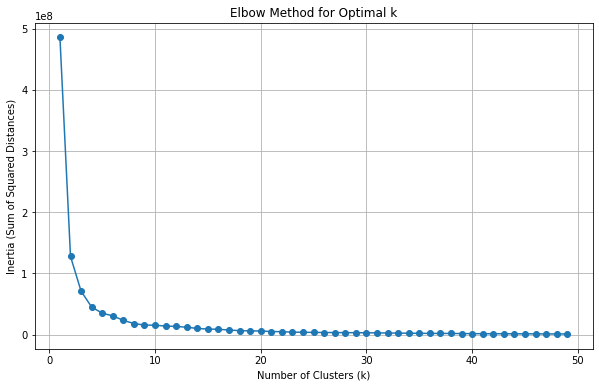

In [130]:
# Clustering based on geographical coordinates for challenge_set_updated

# Extract coordinates for adep and ades
adep_coords = challenge_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords = challenge_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Combine all coordinates for clustering
combined_coords = np.vstack((adep_coords, ades_coords))

# Calculate inertia for each k value in the specified range
inertia = []
k_range = range(1, 50)  # Testing cluster sizes from 1 to 50

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_coords)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()
        
# Automatically determining the optimal k using the "elbow" point
# Finding the point where the reduction in inertia slows down significantly
optimal_k = 1  # Default to 1 cluster if no elbow is detected
threshold_ratio = 0.01  # Define a threshold for identifying the elbow point

# Checking for the point where inertia reduction starts to slow down
for i in range(1, len(inertia) - 1):
    if (inertia[i - 1] - inertia[i]) > (inertia[i] - inertia[i + 1]) * threshold_ratio:
        optimal_k = i + 1
        break

In [131]:
# Apply K-means clustering on combined coordinates
kmeans_geo = KMeans(n_clusters=20, random_state=42)  
kmeans_geo.fit(combined_coords)

# Assign cluster labels back to adep and ades separately
adep_geo_labels = kmeans_geo.predict(adep_coords)
ades_geo_labels = kmeans_geo.predict(ades_coords)

# Map cluster labels to the original dataframe
challenge_set_updated['adep_geo_cluster'] = adep_geo_labels
challenge_set_updated['ades_geo_cluster'] = ades_geo_labels

In [132]:
# Clustering based on geographical coordinates for submission_set_updated

# Extract coordinates for adep and ades from submission_set_updated
adep_coords_submission = submission_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords_submission = submission_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Assign cluster labels back to adep and ades separately for submission_set_updated
adep_geo_labels_submission = kmeans_geo.predict(adep_coords_submission)
ades_geo_labels_submission = kmeans_geo.predict(ades_coords_submission)

# Map cluster labels to the submission_set_updated dataframe
submission_set_updated['adep_geo_cluster'] = adep_geo_labels_submission
submission_set_updated['ades_geo_cluster'] = ades_geo_labels_submission

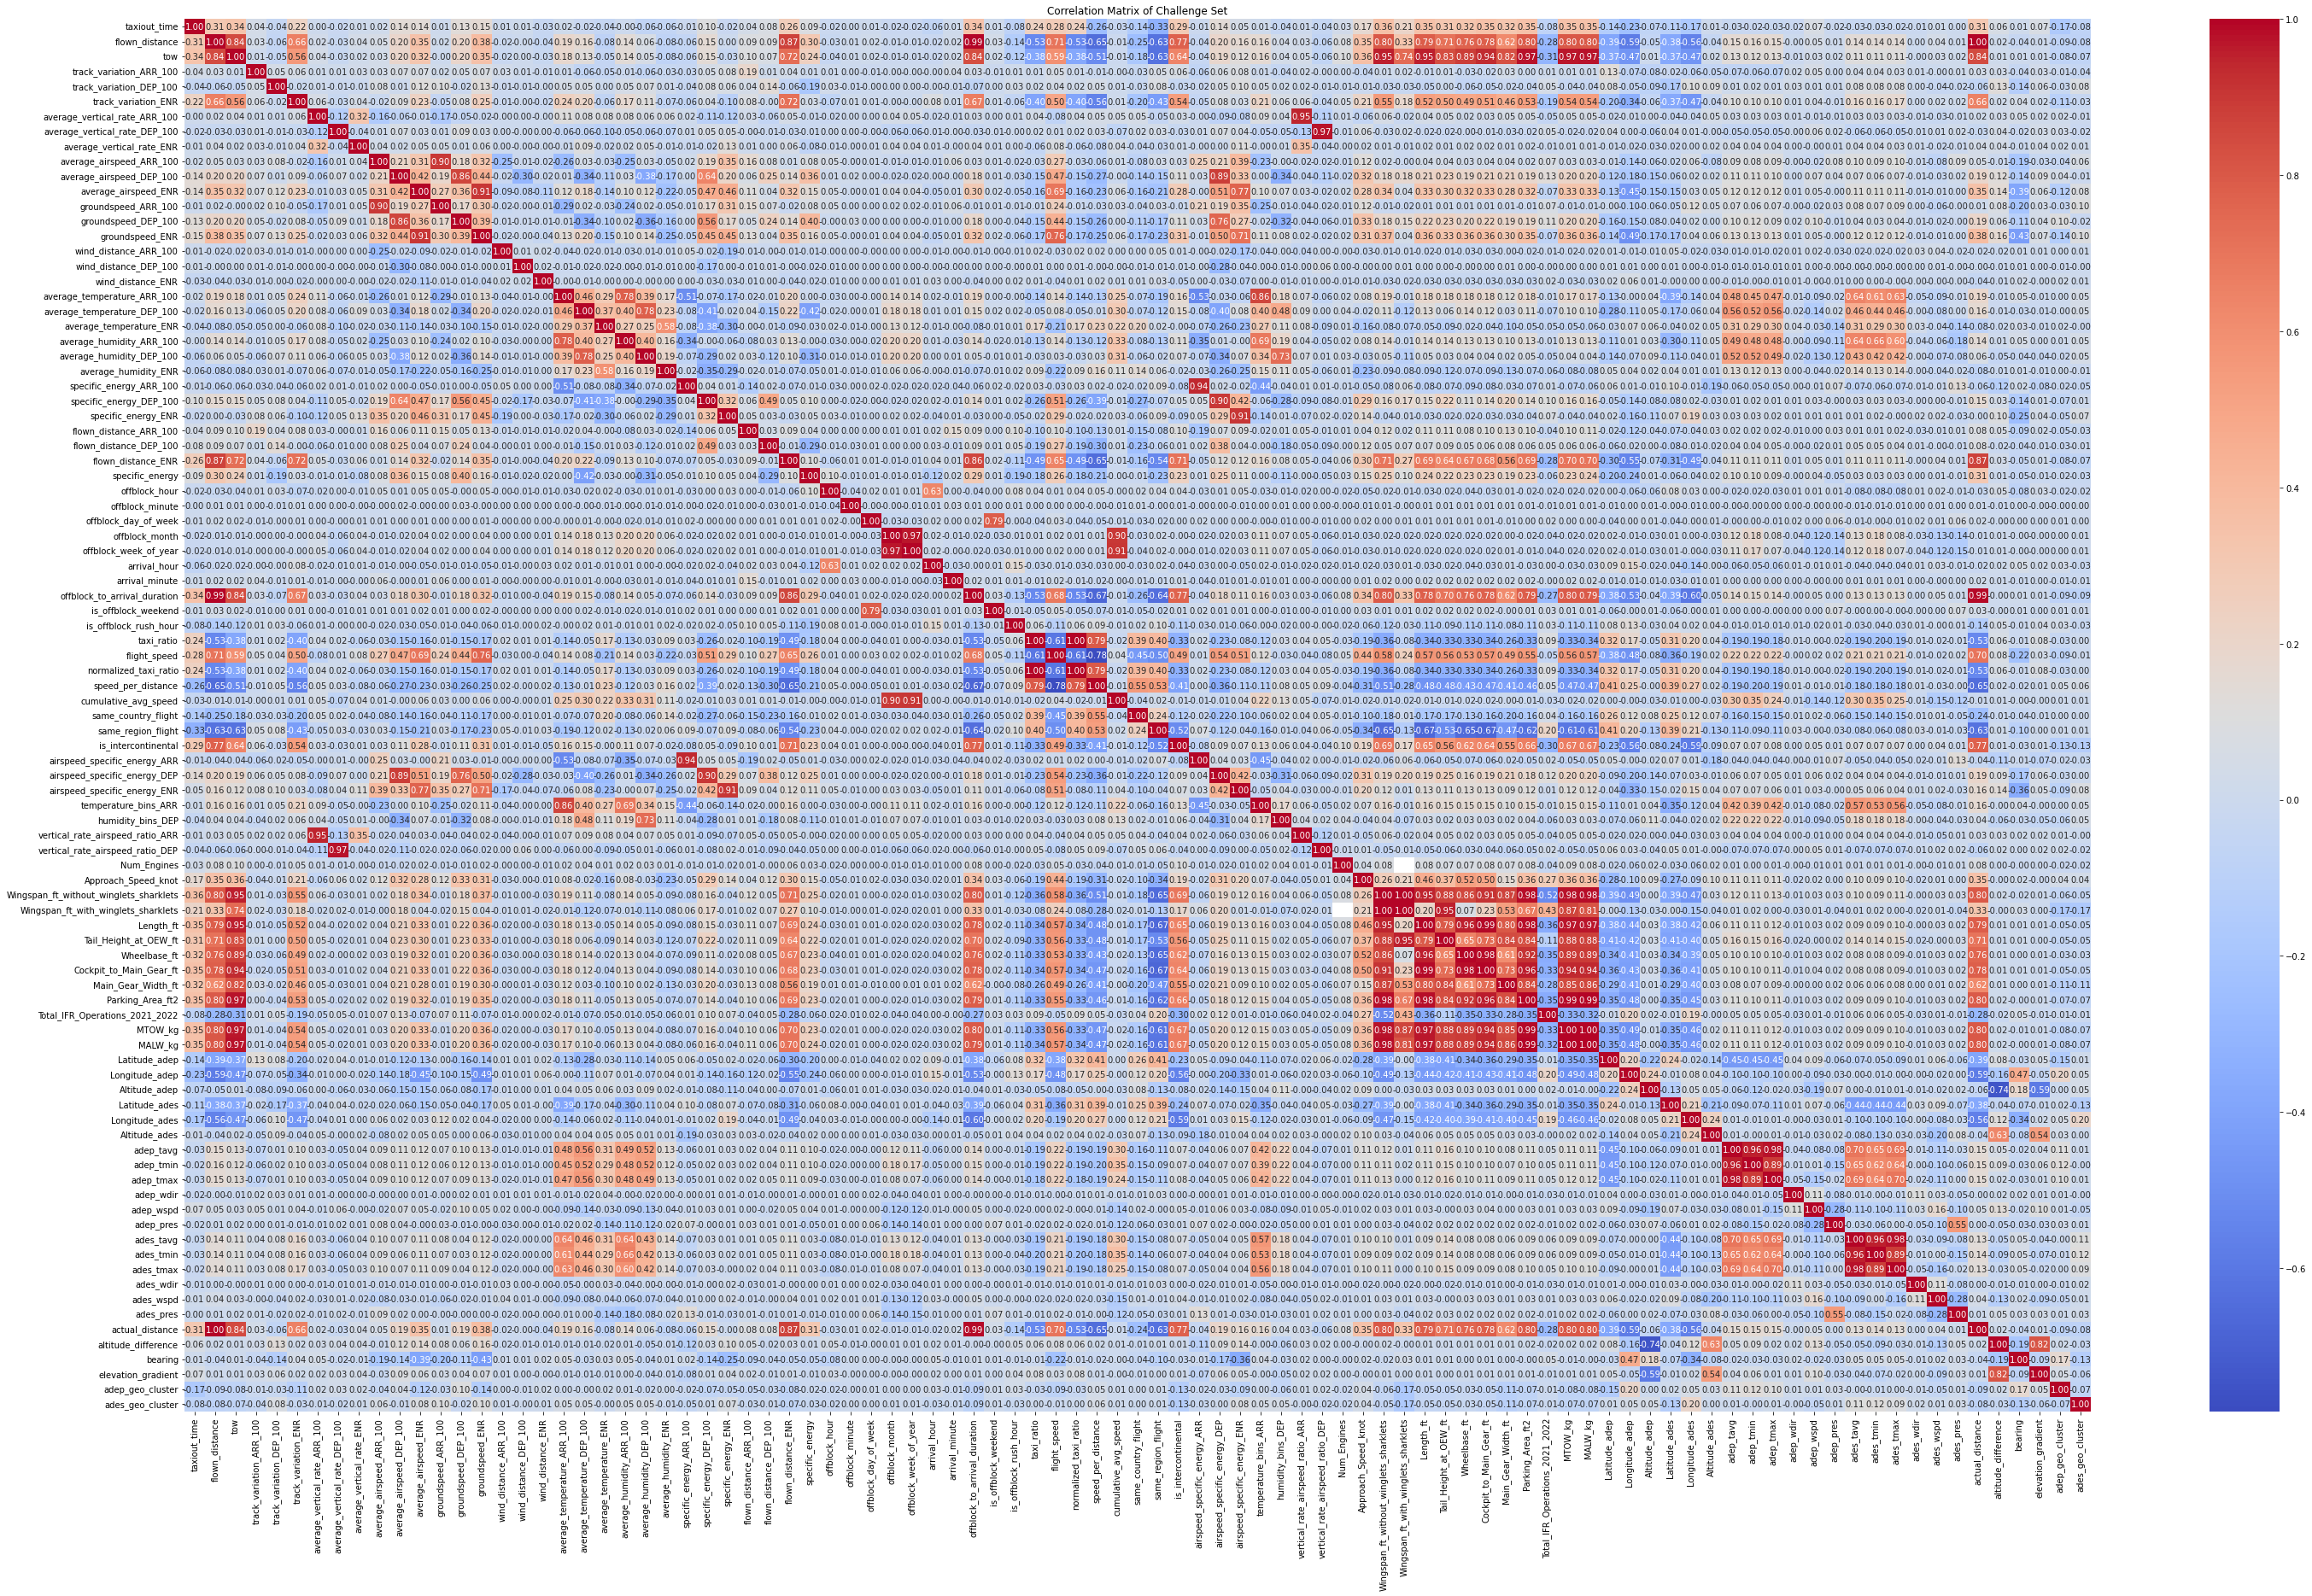

In [133]:
# Summary statistics of the challenge set
challenge_summary = challenge_set_updated.describe()

# Check for missing values
missing_values = challenge_set_updated.isnull().sum()

# Select only numerical columns
numerical_cols = challenge_set_updated.select_dtypes(include=['number'])

# Correlation matrix to check relationships between numerical features
correlation_matrix = numerical_cols.corr()

# Plotting the correlation matrix
plt.figure(figsize=(50, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

In [134]:
list(challenge_set_updated.columns)

['date',
 'adep',
 'ades',
 'aircraft_type',
 'wtc',
 'airline',
 'taxiout_time',
 'flown_distance',
 'tow',
 'track_variation_ARR_100',
 'track_variation_DEP_100',
 'track_variation_ENR',
 'average_vertical_rate_ARR_100',
 'average_vertical_rate_DEP_100',
 'average_vertical_rate_ENR',
 'average_airspeed_ARR_100',
 'average_airspeed_DEP_100',
 'average_airspeed_ENR',
 'groundspeed_ARR_100',
 'groundspeed_DEP_100',
 'groundspeed_ENR',
 'wind_distance_ARR_100',
 'wind_distance_DEP_100',
 'wind_distance_ENR',
 'average_temperature_ARR_100',
 'average_temperature_DEP_100',
 'average_temperature_ENR',
 'average_humidity_ARR_100',
 'average_humidity_DEP_100',
 'average_humidity_ENR',
 'specific_energy_ARR_100',
 'specific_energy_DEP_100',
 'specific_energy_ENR',
 'flown_distance_ARR_100',
 'flown_distance_DEP_100',
 'flown_distance_ENR',
 'specific_energy',
 'offblock_hour',
 'offblock_minute',
 'offblock_day_of_week',
 'offblock_month',
 'offblock_week_of_year',
 'offblock_season',
 'arriva

In [135]:
# List of categorical columns to analyze
categorical_columns = ['aircraft_type', 
                       'wtc', 
                       'airline',
                       'offblock_hour',
                       'offblock_minute', 
                       'offblock_day_of_week',
                       'offblock_month',
                       'offblock_week_of_year', 
                       'offblock_season', 
                       'arrival_hour',
                       'arrival_minute',
                       'is_offblock_weekend',
                       'is_offblock_rush_hour',
                       'flight_duration_category',                       
                       'adep_region', 
                       'ades_region', 
                       'same_country_flight',
                       'same_region_flight',                        
                       'flight_direction',
                       'is_intercontinental',
                       'temperature_bins_ARR',
                       'humidity_bins_DEP',
                       'Physical_Class_Engine',
                       'Num_Engines',
                       'Main_Gear_Config',
                       'FAA_Weight',
                       'adep_geo_cluster',
                       'ades_geo_cluster']

# Calculate the number of unique values for each categorical column efficiently
unique_variations = challenge_set_updated[categorical_columns].nunique()

# Display the number of variations for each categorical variable
unique_variations

aircraft_type               30
wtc                          2
airline                     29
offblock_hour               24
offblock_minute             60
offblock_day_of_week         7
offblock_month              12
offblock_week_of_year       52
offblock_season              4
arrival_hour                24
arrival_minute              60
is_offblock_weekend          2
is_offblock_rush_hour        2
flight_duration_category     4
adep_region                  7
ades_region                  7
same_country_flight          2
same_region_flight           2
flight_direction             3
is_intercontinental          2
temperature_bins_ARR         5
humidity_bins_DEP            5
Physical_Class_Engine        2
Num_Engines                  2
Main_Gear_Config             5
FAA_Weight                   3
adep_geo_cluster            20
ades_geo_cluster            20
dtype: int64

In [136]:
# Function to rearrange the dataframe so that the target variable 'tow' is the last column
def rearrange_columns(df):
    # Moving 'tow' to the last position
    columns = [col for col in df.columns if col != 'tow'] + ['tow']
    df = df[columns]
    return df

# Remove some categorical columns
new_columns_to_remove = ['adep', 'ades', 'date']
challenge_set_updated = remove_columns(challenge_set_updated, new_columns_to_remove)
submission_set_updated = remove_columns(submission_set_updated, new_columns_to_remove)

# Apply One-Hot Encoding to the training set
challenge_set_updated = pd.get_dummies(challenge_set_updated, columns=categorical_columns, drop_first=True)

# Apply One-Hot Encoding to the test set
submission_set_updated = pd.get_dummies(submission_set_updated, columns=categorical_columns, drop_first=True)

# Align the test set columns with the training set columns
# Identify missing columns and create a DataFrame with those columns set to zero
missing_cols = set(challenge_set_updated.columns) - set(submission_set_updated.columns)
missing_cols_df = pd.DataFrame(0, index=submission_set_updated.index, columns=list(missing_cols))

# Concatenate the missing columns DataFrame with the test set
submission_set_updated = pd.concat([submission_set_updated, missing_cols_df], axis=1)

# Drop extra columns in the test set that are not in the training set
extra_cols = set(submission_set_updated.columns) - set(challenge_set_updated.columns)
submission_set_updated.drop(columns=list(extra_cols), inplace=True)

# Reorder the columns of the test set to match the training set
submission_set_updated = submission_set_updated[challenge_set_updated.columns]

# Rearrange columns
challenge_set_updated = rearrange_columns(challenge_set_updated)
submission_set_updated = rearrange_columns(submission_set_updated)


In [137]:
missing_cols

{'FAA_Weight_Small+',
 'Main_Gear_Config_S',
 'adep_region_South America',
 'ades_region_South America',
 'aircraft_type_A310',
 'aircraft_type_C56X',
 'airline_154acc473ac7d5991245125f4ff6b3a6',
 'airline_310d41975a1e6b9b51ca356414d67daf',
 'airline_415bb6c2faf8f0aa7b4108deeec9869c',
 'airline_588c4a7c5b7320c61a6c4227be465964',
 'airline_6a681ee572c1e4e981cdab3c55b4b422',
 'airline_72ba06dd5ae13526df103042ce4c535e',
 'airline_b37a3f3161e6ec4cffbb65e7ebf4ecfe',
 'airline_cc0752e0930c0f501873a342d96c13f0',
 'airline_ecae30f8b0a678b4e97d1f7307642d2b'}

In [138]:
extra_cols

{'airline_e5b13da1511ff741c34c94cfd5575c55'}

In [139]:
challenge_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,369003,369004,369005,369006,369007,369008,369009,369010,369011,369012
taxiout_time,18.000000,13.000000,15.000000,11.000000,14.000000,27.000000,10.000000,25.000000,10.000000,25.000000,...,18.000000,19.000000,25.000000,9.000000,8.000000,21.000000,25.000000,11.000000,12.000000,16.000000
flown_distance,321.000000,4193.000000,3770.000000,3607.000000,305.000000,1434.000000,295.000000,458.000000,6354.000000,257.000000,...,726.000000,449.000000,975.000000,782.000000,416.000000,4046.000000,946.000000,522.000000,466.000000,3213.000000
track_variation_ARR_100,124.339907,179.318890,179.638848,0.208347,NaN,129.426353,156.984462,17.706362,23.829551,119.350942,...,41.225296,64.982306,NaN,38.678060,70.340447,174.768738,62.544950,43.910303,48.439184,NaN
track_variation_DEP_100,39.704139,8.910306,32.391881,36.998783,174.878799,22.836441,86.126276,178.849514,NaN,NaN,...,107.075354,174.543182,0.397226,0.815619,11.825033,9.528459,22.872438,18.479277,28.660678,23.802205
track_variation_ENR,2.102124,76.029652,85.115541,101.712676,NaN,14.447133,35.653151,5.485476,99.558897,NaN,...,86.102977,28.889307,17.529504,27.643538,19.299673,4.913511,26.244336,19.499181,35.779227,20.291439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ades_geo_cluster_16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ades_geo_cluster_17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ades_geo_cluster_18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ades_geo_cluster_19,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [140]:
submission_set_updated.T

,0,1,2,3,4,5,6,7,8,9,...,105949,105950,105951,105952,105953,105954,105955,105956,105957,105958
taxiout_time,15.000000,15.000000,10.000000,10.000000,15.000000,15.000000,10.000000,9.000000,15.000000,11.000000,...,5.000000,15.000000,25.000000,35.000000,10.000000,15.000000,14.000000,25.000000,9.000000,10.000000
flown_distance,1122.000000,3205.000000,3965.000000,986.000000,686.000000,239.000000,251.000000,415.000000,321.000000,806.000000,...,744.000000,1160.000000,3540.000000,3437.000000,4595.000000,1199.000000,3937.000000,988.000000,240.000000,1014.000000
track_variation_ARR_100,NaN,98.664855,26.478102,102.257838,5.653190,148.324583,46.441083,23.051526,115.933692,NaN,...,25.423968,107.050329,NaN,NaN,179.108802,7.501187,63.604558,144.759230,168.724666,NaN
track_variation_DEP_100,110.069323,64.755647,73.771503,176.128681,169.820834,163.189758,35.655823,92.356573,34.157924,0.358094,...,NaN,NaN,30.884164,73.396095,NaN,0.129044,130.091684,14.621142,166.830531,NaN
track_variation_ENR,50.723775,93.023665,5.682069,48.209089,50.924346,NaN,1.108743,8.516241,7.136105,6.443916,...,0.498768,26.121616,2.013310,2.502445,4.106901,0.132323,129.422361,19.623618,NaN,33.638622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ades_geo_cluster_16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ades_geo_cluster_17,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ades_geo_cluster_18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ades_geo_cluster_19,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [141]:
challenge_set_updated.to_csv('./data/challenge_set_updated_v11.csv', index=False)
submission_set_updated.to_csv('./data/submission_set_updated_v11.csv', index=False)